# Experiment 3 Notebook

set up based on https://keras.io/examples/audio/ctc_asr/


In [1]:
# !pip install jiwer
# !pip install pandas
# !pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

import torch
device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)


%matplotlib inline

cpu


for running downloading data from internet

In [2]:
# data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
# data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
# wavs_path = data_path + "/wavs/"
# metadata_path = data_path + "/metadata.csv"


# # Read metadata file and parse it
# metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
# metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
# metadata_df = metadata_df[["file_name", "normalized_transcription"]]
# metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
# metadata_df.head(3)


for loading data from computer

In [3]:
# data_path = "/home/ryanwhetten/Downloads/LJSpeech-1.1"
data_path = "/home/slimlab/Downloads/LJSpeech-1.1"
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ033-0033,there were two flat lightweight curtain rods b...
1,LJ034-0007,The Commission evaluated the physical evidence...
2,LJ017-0216,"there were also a Frenchman, a Norwegian (the ..."


In [4]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


In [5]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [6]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from tensorflow.python.ops.gen_spectral_ops import fft
# int. scalar tensor. window length in samples
frame_length = 256
# int. scalar tensor. number of samples to step
frame_step = 160
# int scalar tensor. size of FFT
fft_length = 384

def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")

    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float, this step might not be necessary
    audio = tf.cast(audio, tf.float32)

    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, 
        frame_length=frame_length, 
        frame_step=frame_step, 
        fft_length=fft_length
    )

    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)

    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    # 9. Map the characters in label to numbers
    label = char_to_num(label)

    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label


In [9]:
encode_single_sample(metadata_df.file_name[0], metadata_df.normalized_transcription[0])


(<tf.Tensor: shape=(1048, 193), dtype=float32, numpy=
 array([[ 1.9096268 ,  2.891037  ,  3.3773243 , ..., -0.8367311 ,
         -0.87170875, -1.0365374 ],
        [ 1.9869508 ,  3.1935897 ,  3.0331132 , ..., -0.60734284,
         -0.5000294 , -0.45574087],
        [ 0.50411093,  0.75398445,  0.30140924, ..., -0.4036791 ,
         -0.40261766, -0.40601188],
        ...,
        [-0.2890994 ,  1.5821801 ,  2.5040574 , ..., -0.91710335,
         -0.9554804 , -1.0164249 ],
        [ 1.0616128 ,  0.7996552 ,  1.4381399 , ..., -0.9554492 ,
         -1.0125132 , -1.0381517 ],
        [ 0.92544186,  1.4194813 ,  1.3960557 , ..., -1.0462846 ,
         -1.0667093 , -1.0322883 ]], dtype=float32)>,
 <tf.Tensor: shape=(107,), dtype=int64, numpy=
 array([23, 18,  5, 19, 20, 12,  9, 14,  7,  0, 30,  9, 14, 30, 23,  8,  9,
         3,  8, 30, 12,  5,  7, 19, 30, 23,  5, 18,  5, 30, 15,  3,  3,  1,
        19,  9, 15, 14,  1, 12, 12, 25, 30,  2, 18, 15, 11,  5, 14,  0, 30,
        23,  1, 19, 30,  6, 

In [10]:
batch_size = 32

# define training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

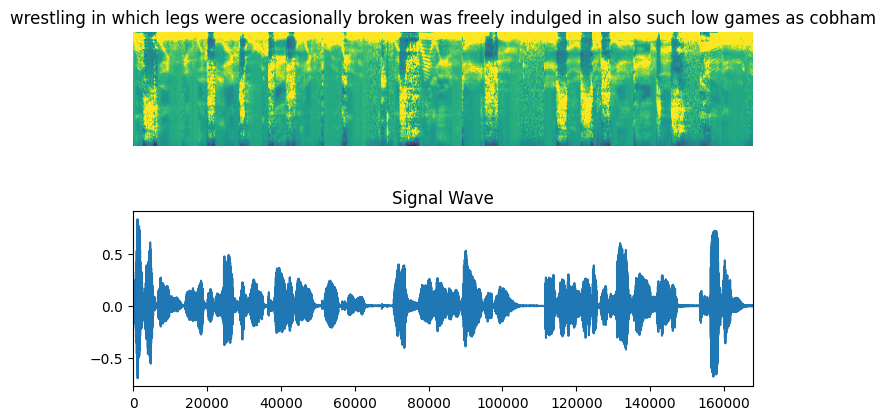

In [11]:
fig = plt.figure(figsize=(8,5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))

plt.show()

In [12]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [13]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# Play to figure out custom loss function

In [14]:
def get_cos_sim(s, s1, model=minilm):
    embedding_s = model.encode(s, convert_to_tensor=True)
    embedding_s1 = model.encode(s1, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding_s, embedding_s1)

In [15]:
def get_respective_cos_sim(s, s1, model=minilm):
    cos_sim = get_cos_sim(s, s1, model)
    return cos_sim.diagonal()

In [16]:
def relu(x):
    return torch.max(torch.tensor(0.0000001),x)

In [17]:
test = torch.tensor([-0.0550,  0.0071,  0.1290,  0.2937])
test
relu(test)

tensor([1.0000e-07, 7.1000e-03, 1.2900e-01, 2.9370e-01])

In [18]:
def get_cos_loss(s, s1, model=minilm):
    cos_sim = get_respective_cos_sim(s, s1, model)
    # remove negatives and look at neg loglikilood
    cos_sim = relu(cos_sim).reshape((len(s),1))
    return -np.log(cos_sim.cpu()).numpy()

In [19]:
gt = []
for X, y in train_dataset:
#     print(num_to_char(y))
#     print(X)
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        print(label)
        gt.append(label)
    break

wrestling in which legs were occasionally broken was freely indulged in also such low games as cobham
oswald quote seemed to be a person who would go out of his way to get into trouble end quote
on his return to newgate to be finally discharged cummings jumped up the stairs and fairly danced for joy
in this connection the commission considered one
there have been references to the numerous discussions between secret service representatives and the dallas police department
who was becoming quite a disciplinary problem for his mother having struck her on at least one occasion
radical improvement was generally considered impossible the great evil however had been sensibly diminished
neild found at his visit to newgate in eighteen ten
he sought to rebut these charges which indeed were never clearly made out and it is pretty certain that his own account of the causes which led him into dishonesty
this was the first enunciation of the system of separate confinement
was the case of the forger

In [20]:
batch_predictions = model_cos.predict(X)

batch_predictions = decode_batch_predictions(batch_predictions)

NameError: name 'model_cos' is not defined

In [21]:
batch_predictions

NameError: name 'batch_predictions' is not defined

In [22]:
# batch_pred_decode = decode_batch_predictions(batch_predictions)

In [23]:
# batch_pred_decode

In [24]:
get_cos_sim(gt, batch_predictions).shape
# minilm.encode('hi', convert_to_tensor=True)

NameError: name 'batch_predictions' is not defined

In [25]:
# 1 - get_cos_sim(gt[0:2], batch_pred_decode[0:2])


Playing around w/get batches of cosine similarities

In [26]:
get_cos_sim(gt, gt)


tensor([[ 1.0000e+00,  1.2256e-01,  2.1608e-01,  ...,  1.6737e-02,
          1.0117e-01,  3.4375e-02],
        [ 1.2256e-01,  1.0000e+00,  1.3732e-01,  ..., -2.9009e-02,
          1.8485e-02,  1.3814e-01],
        [ 2.1608e-01,  1.3732e-01,  1.0000e+00,  ...,  1.3633e-02,
          1.3773e-01, -3.8151e-02],
        ...,
        [ 1.6737e-02, -2.9009e-02,  1.3633e-02,  ...,  1.0000e+00,
         -4.7212e-02, -9.8544e-03],
        [ 1.0117e-01,  1.8485e-02,  1.3773e-01,  ..., -4.7212e-02,
          1.0000e+00, -1.3825e-04],
        [ 3.4375e-02,  1.3814e-01, -3.8151e-02,  ..., -9.8544e-03,
         -1.3825e-04,  1.0000e+00]], device='cuda:0')

In [27]:
gt_sim = [
    'promptly closed three days later for some random reasons by the renters',
    'but reformation was soley skin deep under the surface many of the old evils still rankled',
    'he read the letter but refused to believe that it was sincere even though his wife afirmed to him that it was',
    'they entered a stone cold room and were presently joined by the prisoner',
]

In [28]:
get_cos_sim(gt, gt_sim)


tensor([[ 0.0150,  0.0567,  0.0602,  0.1001],
        [ 0.0913,  0.1044,  0.3287,  0.1903],
        [ 0.0745, -0.0319,  0.1370,  0.2356],
        [ 0.1304,  0.0770,  0.1292,  0.0888],
        [ 0.0976,  0.0868,  0.0657,  0.1949],
        [ 0.1097,  0.1157,  0.2683,  0.0892],
        [-0.0384,  0.5506,  0.1426,  0.0698],
        [ 0.1433,  0.0316,  0.1282,  0.2138],
        [ 0.1252,  0.1427,  0.4202,  0.1590],
        [ 0.0047,  0.1981,  0.0044,  0.2889],
        [ 0.1352,  0.1864,  0.1405,  0.1803],
        [ 0.1848,  0.2930,  0.1221,  0.1556],
        [ 0.1484, -0.0013,  0.2568,  0.2694],
        [ 0.0834,  0.1456,  0.0933,  0.1304],
        [ 0.0910,  0.0559, -0.0061,  0.1346],
        [ 0.1155,  0.0721, -0.0015,  0.2783],
        [ 0.0439,  0.0806,  0.0814,  0.0421],
        [ 0.2380,  0.1311,  0.0762,  0.3868],
        [ 0.1704,  0.0186,  0.4547,  0.1440],
        [ 0.0137,  0.0375, -0.1388, -0.0747],
        [ 0.2028,  0.0776,  0.0783,  0.3727],
        [ 0.1501,  0.1851,  0.0621

In [29]:
get_cos_sim(gt, gt_sim).diagonal()

# (1-get_cos_sim(gt, batch_pred_decode).diagonal()).mean()

tensor([0.0150, 0.1044, 0.1370, 0.0888], device='cuda:0')

In [30]:
def get_labels(y):
    gt = []
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        gt.append(label)
    return gt

In [31]:
get_labels(y)

['wrestling in which legs were occasionally broken was freely indulged in also such low games as cobham',
 'oswald quote seemed to be a person who would go out of his way to get into trouble end quote',
 'on his return to newgate to be finally discharged cummings jumped up the stairs and fairly danced for joy',
 'in this connection the commission considered one',
 'there have been references to the numerous discussions between secret service representatives and the dallas police department',
 'who was becoming quite a disciplinary problem for his mother having struck her on at least one occasion',
 'radical improvement was generally considered impossible the great evil however had been sensibly diminished',
 'neild found at his visit to newgate in eighteen ten',
 'he sought to rebut these charges which indeed were never clearly made out and it is pretty certain that his own account of the causes which led him into dishonesty',
 'this was the first enunciation of the system of separate 

In [32]:
def CTC_Cosine_Loss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    y_true_labs = get_labels(y_true)
    # print(y_true_labs)
    y_pred_labs = decode_batch_predictions(y_pred)
    # print(y_pred_labs)
    cos_loss = get_cos_loss(y_true_labs, y_pred_labs)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(cos_loss)
    return loss + cos_loss

In [33]:
batch_predictions = model_cos(X)
batch_predictions_decoded = decode_batch_predictions(batch_predictions)
batch_predictions_decoded
# batch_predictions = model.predict(X)

# batch_predictions = decode_batch_predictions(batch_predictions)

NameError: name 'model_cos' is not defined

In [34]:
get_labels(y)

['wrestling in which legs were occasionally broken was freely indulged in also such low games as cobham',
 'oswald quote seemed to be a person who would go out of his way to get into trouble end quote',
 'on his return to newgate to be finally discharged cummings jumped up the stairs and fairly danced for joy',
 'in this connection the commission considered one',
 'there have been references to the numerous discussions between secret service representatives and the dallas police department',
 'who was becoming quite a disciplinary problem for his mother having struck her on at least one occasion',
 'radical improvement was generally considered impossible the great evil however had been sensibly diminished',
 'neild found at his visit to newgate in eighteen ten',
 'he sought to rebut these charges which indeed were never clearly made out and it is pretty certain that his own account of the causes which led him into dishonesty',
 'this was the first enunciation of the system of separate 

In [35]:
CTCLoss(y, batch_predictions)

NameError: name 'batch_predictions' is not defined

In [36]:
CTC_Cosine_Loss(y, batch_predictions)

NameError: name 'batch_predictions' is not defined

## Model

In [37]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128, loss=CTCLoss):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=loss, run_eagerly=True)
#     model.compile(optimizer=opt, loss=loss)
    
    return model




In [38]:
model_base = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
    loss=CTCLoss,
)

In [45]:
model_cos = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
    loss=CTC_Cosine_Loss,
    
)

In [46]:
model_cos.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 97, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizati  (None, None, 97, 32)     128       
 on)                                                             
                                                                 
 conv_1_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 49, 32)      236544    
                                                      

In [47]:
# # get model
# model_base = build_model(
#     input_dim=fft_length // 2 + 1,
#     output_dim=char_to_num.vocabulary_size(),
#     rnn_units=512,
#     loss=CTCLoss
# )
# model_base.summary(line_length=110)

In [48]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
#         avg_cos_dis = get_avg_cos_dis(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
#         print(f"Avg. Cos Dis: {avg_cos_dis:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
#             print(f"Avg. Cos Dis: {get_avg_cos_dis(targets[i], predictions[i]):.4f}")
            print("-" * 100)
            
            

Run Model

In [53]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history_base = model_base.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

 123/2948 [>.............................] - ETA: 2:18:58 - loss: 324.0783


KeyboardInterrupt



In [49]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history_base = model_cos.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

InternalError: Exception encountered when calling layer 'forward_gru_1' (type GRU).

{{function_node __wrapped__CudnnRNN_device_/job:localhost/replica:0/task:0/device:GPU:0}} Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 3, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 1568, 512, 1, 679, 32, 0]  [Op:CudnnRNN]

Call arguments received by layer 'forward_gru_1' (type GRU):
  • inputs=tf.Tensor(shape=(32, 679, 1568), dtype=float32)
  • mask=None
  • training=True
  • initial_state=None

In [41]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model_base.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
    break
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 [==============================] - 0s 229ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : its receipt was immediately followed by the promulgation of its contents to the persons most closely concerned
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : its receipt was immediately followed by the promulgation of its contents to the persons most closely concerned
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the second test run required one minute and fifteen seconds
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the second test run required one minute and fifte

In [ ]:
tf.strings.reduce_join(num_to_char([1, 2, 3])).numpy().decode("utf-8")

In [ ]:
decode_batch_predictions(b)

In [ ]:
a = np.array([
    [[1],[1],[1]], 
    [[2],[2],[2]], 
    [[3],[3],[3]]
])
b = tf.constant(a, dtype="int64")
b

In [ ]:
tf.compat.v1.transpose(b, perm=[1,0])

In [ ]:
tf.compat.v1.transpose(b, perm=[0,1])